In [1]:
from scipy.io import loadmat
from torch.utils.data import Dataset
from torch import nn
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from gan import Generator, Discriminator

In [2]:

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [3]:
mnist = loadmat("../mnist-original.mat/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

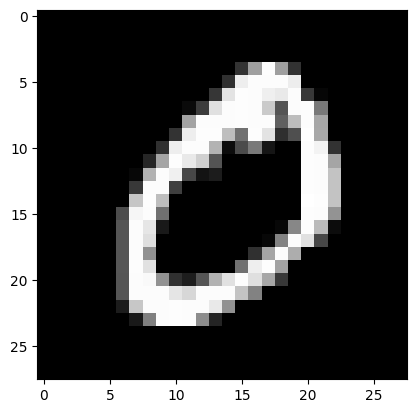

In [4]:
plt.imshow(mnist_data[0].reshape(28, 28), cmap="gray")

In [5]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.reshape(28, 28)),
    transforms.ToTensor(),
])

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx]), self.label[idx]

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
EPOCHS = 10
batch_size = 64
num_workers = 8
lr = 2e-4
k = 1
latent_dim = 128

In [9]:
import wandb
wandb.login()

run =  wandb.init(
    project="GAN_BCE_MNIST",
    # entity="mnist_diffusion",
    name=f"lr_{lr}_latent_dim_{latent_dim}_k_{k}",
    config={
        "epochs": EPOCHS,
        "batch_size": batch_size,
        "num_workers": num_workers,
        "lr": lr,
        "latent_dim": latent_dim,
        "k": k,
    }
)

wandb: Currently logged in as: debugzwang (debugzwang-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [10]:
generator = Generator(latent_dim)
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
def d_loss_bce(d, real_imgs, fake_imgs, adversarial_loss_fn=torch.nn.BCELoss()):
    real_validity = d(real_imgs)
    fake_validity = d(fake_imgs)
    real_labels = torch.ones(real_imgs.size(0), 1).to(real_imgs.device)
    real_adversarial_loss = adversarial_loss_fn(real_validity, real_labels)
    fake_labels = torch.zeros(fake_imgs.size(0), 1).to(fake_imgs.device)
    fake_adversarial_loss = adversarial_loss_fn(fake_validity, fake_labels)
    return (real_adversarial_loss + fake_adversarial_loss)/2

def g_loss_bce(d, real_imgs, fake_imgs, adversarial_loss_fn=torch.nn.BCELoss()):
    fake_validity = d(fake_imgs)
    real_labels = torch.ones(real_imgs.size(0), 1).to(real_imgs.device)
    adversarial_loss = adversarial_loss_fn(fake_validity, real_labels)
    return adversarial_loss


def train(
        generator: Generator,
        discriminator: Discriminator,
        d_optimizer: torch.optim.Optimizer,
        g_optimizer: torch.optim.Optimizer,
        epochs: int,
        device: str,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        k: int = 5,
):
    adversarial_loss_fn=torch.nn.BCELoss()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        discriminator.eval()
        generator.eval()
        val_d_loss = 0
        val_g_loss = 0
        images = None
        with torch.no_grad():
            for index, (imgs, labels) in enumerate(val_dataloader):
                imgs = imgs.to(device)
                z = torch.randn(imgs.size(0), generator.latent_dim).to(device)
                fake_imgs = generator(z)
                d_loss_value = d_loss_bce(discriminator, imgs, fake_imgs.detach(), adversarial_loss_fn)
                g_loss_value = g_loss_bce(discriminator, imgs, fake_imgs, adversarial_loss_fn)
                val_d_loss += d_loss_value.item()
                val_g_loss += g_loss_value.item()
                if epoch % 10 == 0 and index == 0:
                    z = torch.randn(imgs.size(0), generator.latent_dim).to(device)
                    output = generator(z)
                    images = [wandb.Image(output[i].squeeze(0).cpu().numpy()) for i in range(1)]
        discriminator.train()
        generator.train()
        training_d_loss = 0
        training_g_loss = 0
        def train_generator(z):
            g_optimizer.zero_grad()
            fake_imgs = generator(z)
            loss = g_loss_bce(discriminator, fake_imgs, fake_imgs, adversarial_loss_fn)
            loss.backward()
            g_optimizer.step()
            return loss.item()
        def train_discriminator(real_imgs, fake_imgs):
            d_optimizer.zero_grad()
            loss = d_loss_bce(discriminator, real_imgs, fake_imgs, adversarial_loss_fn)
            loss.backward()
            d_optimizer.step()
            return loss.item()

        for index, (imgs, _) in enumerate(train_dataloader):
            imgs = imgs.to(device)
            for _ in range(k):
                z = torch.randn(imgs.size(0), generator.latent_dim).to(device)
                fake_imgs = generator(z)
                training_d_loss += train_discriminator(imgs, fake_imgs.detach()) / k

            z = torch.randn(imgs.size(0), generator.latent_dim).to(device)  
            training_g_loss += train_generator(z)

        # 创建一个表格，其中每行代表一个 embedding
        log_data = {
            "epoch": epoch,
            "training_d_loss": training_d_loss / len(train_dataloader),
            "training_g_loss": training_g_loss / len(train_dataloader),
            "validation_d_loss": val_d_loss / len(val_dataloader),
            "validation_g_loss": val_g_loss / len(val_dataloader),

        }
        if images is not None:
            log_data["validation_images"] = images
        wandb.log(log_data)


In [12]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
for model in [generator, discriminator]:
    model.apply(weights_init_normal)
    print(f"Initialized {model.__class__.__name__} weights.")

Initialized Generator weights.
Initialized Discriminator weights.


In [13]:
from torch.utils.data import random_split

# Assuming mnist_data and mnist_label are already defined
dataset = MNISTDataset(mnist_data, mnist_label, transform=transform)

# Define the lengths for training and validation sets
train_size = 50000
val_size = 10000
# train_size = 500
# val_size = 100
test_size = len(dataset) - train_size - val_size
# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Now you can use train_dataset and val_dataset with DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [14]:
train(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=optimizer_G,
    d_optimizer=optimizer_D,
    epochs=EPOCHS,
    device=device,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    k=k
)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [15]:
from matplotlib import pyplot as plt
import torchvision.utils as vutils
def show_images(images):
    grid = vutils.make_grid(images, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')  # 调整维度顺序
    plt.axis('off')
    plt.show()
    plt.close()

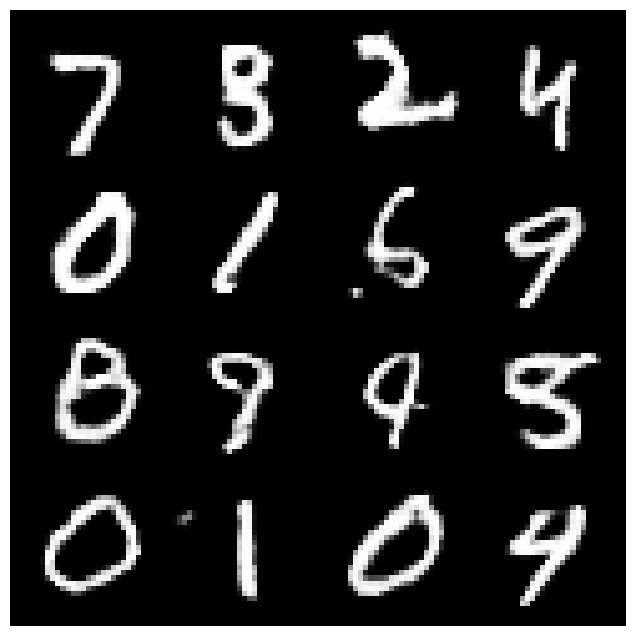

In [16]:
z = torch.randn(16, generator.latent_dim).to(device)
with torch.no_grad():
    generated_images = generator(z)
show_images(generated_images.cpu().detach())


In [17]:
import os
os.makedirs(f"/mnt/d/data/mnist_model/GAN_BCE", exist_ok=True)
torch.save(generator.state_dict(), f"/mnt/d/data/mnist_model/GAN_BCE/g_lr_{lr}_epoch_{EPOCHS}_latent{latent_dim}_k_{k}.pth")
torch.save(discriminator.state_dict(), f"/mnt/d/data/mnist_model/GAN_BCE/d_lr_{lr}_epoch_{EPOCHS}_latent{latent_dim}_k_{k}.pth")